# Movie recomendation system
This notebook was written as a part of an evaluation assignment for Styria from September 30th to October 16th 2017 in Zagreb, Croatia by Ivan Pandžić. The evaluation assignment consists of four parts:
1. Exploring the MovieLens 20M Dataset and specifying interesting findings about it.
2. Developing a software solution, using Python 3, which will be able to suggest to users which movies to watch based on their ratings of previously watched movies. 
3. Evaluating the software solution described in (2.).
4. Presenting the software solution in a suitable form (for instance, an ipynb).

In solving these tasks, I used numpy, pandas, matplotlib, scikit-learn, ...

In [1]:
import re
from math import sqrt
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cross_validation as cv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Exploring the MovieLens 20M Dataset


The MovieLens 20M Dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies.

In order to explore the the MovieLens 20M Dataset, we first load the six csv files from the ml-20m folder (`genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`) and convert them into DataFrames using pandas.

In [5]:
movies = pd.read_csv('ml-20m/movies.csv')
print(movies.shape)
movies.head()

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The **movies** dataframe has 27278 rows and three columns labeled **movieId**, **title** and **genres**. In order to make the dataframe more usable, we add seperate columns for each genre and delete the **genres** column which we do not need anymore. We also delete the newly created **(no genres listed)** column, which doesn't seem useful.

In [6]:
movies = pd.concat([movies, movies.genres.str.get_dummies(sep='|')], axis=1)
del movies["genres"]
del movies["(no genres listed)"]
print(movies.shape)
movies.head()

(27278, 21)


,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The **movies** dataframe now has 21 columns instead of three: **movieId**, **title**, **Action**, **Adventure**, **Animation**, **Children**, **Comedy**, **Crime**, **Documentary**, **Drama**, **Fantasy**, **Film-Noir**, **Horror**, **IMAX**, **Musical**, **Mystery**, **Romance**, **Sci-Fi**, **Thriller**, **War** and **Western**.

We create a year_list in order to plot a year distribution bar chart.

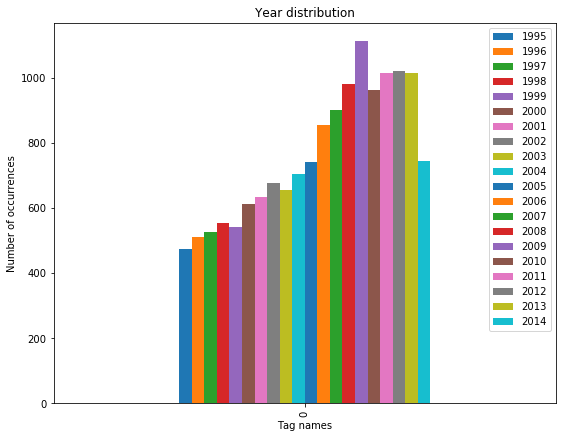

In [7]:
year_list = []
for row in movies["title"]:
    x = re.search(r"\(\d{4}\)", row)
    if x:
        y = x.group(0)
    year_list.append(y[1:-1])

year_count = Counter(year_list)
year_count_30 = year_count .most_common(20)
year_dict = dict(year_count_30)
year_df = pd.DataFrame(year_dict, index=[0])

plt.rcParams["figure.figsize"] = [9,7]
ax = year_df.plot(kind='bar', title="Year distribution")
ax.set_xlabel("Tag names")
ax.set_ylabel("Number of occurrences")

The data in MovieLens 20M was created between January 09, 1995 and March 31, 2015, so it is reasonable that movies released in 2015 are not represented in the top 20 of the Year distribution bar graph. It is also reasonable that movies released prior to 1985 are not in the top 20 of the Year distribution bar graph, since the data was collected between January 09, 1995 and March 31, 2015.

In [8]:
movies.loc["Total"] = movies.sum(numeric_only=True)
movies.iloc[-1, movies.columns.get_loc('movieId')] = "None"
movies.tail()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
27274,131256,"Feuer, Eis & Dosenbier (2002)",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27275,131258,The Pirates (2014),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27276,131260,Rentun Ruusu (2001),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27277,131262,Innocence (2014),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Total,None,NaN,3520.0,2329.0,1027.0,1139.0,8374.0,2939.0,2471.0,13344.0,...,330.0,2611.0,196.0,1036.0,1514.0,4127.0,1743.0,4178.0,1194.0,676.0


We calculate a total of different genres for the entire **movies** dataframe in order to create a Genre distribution bar chart.

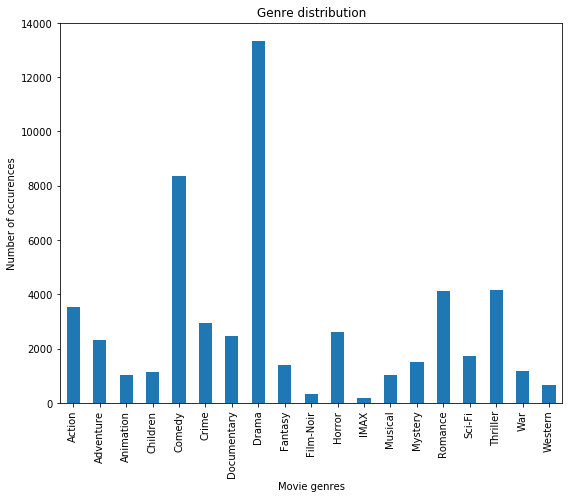

In [10]:
total_row = movies.iloc[-1]
total_row = total_row.drop(['movieId', 'title'])
plt.xlabel("Movie genres")
plt.ylabel("Number of occurences")
plt.title("Genre distribution")
total_row.plot(kind='bar')

As we can see from the bar chart, **Drama**, **Comedy**, **Thriller**, **Romance** and **Action** are the five most frequent genres in the MovieLens 20M dataset.

In [11]:
ratings = pd.read_csv('ml-20m/ratings.csv')
print(ratings.shape)
ratings.head()

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [12]:
ratings_mean = ratings["rating"].mean()
print(ratings_mean)

3.5255285642993797


The **ratings** dataframe has 20000263 rows and four columns labeled **userId**, **movieId**, **rating** and **timestamp**. The ratings mean is 3.526.

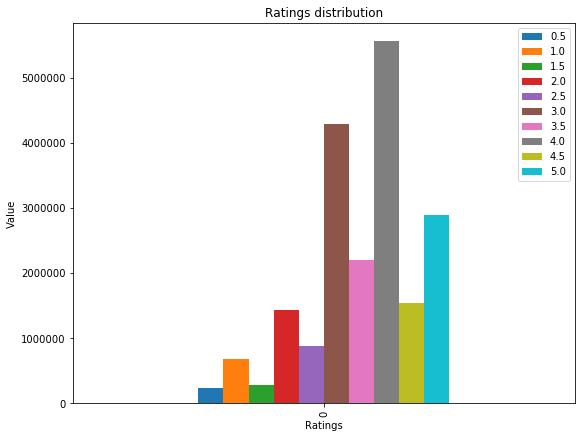

In [22]:
ratings_list = ratings["rating"].tolist()
ratings_count = Counter(ratings_list)

ratings_count_dict = dict(ratings_count)


plt.rcParams["figure.figsize"] = [9,7]

raings_count_df = pd.DataFrame(ratings_count_dict, index=[0])
ax = raings_count_df.plot(kind='bar', title="Ratings distribution")
ax.set_xlabel("Ratings")
ax.set_ylabel("Value")

In [12]:
tags = pd.read_csv('ml-20m/tags.csv')
print(ratings.shape)
tags.head()

(20000263, 4)


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


The **tags** dataframe has 20000263 rows and four columns labeled **userId**, **movieId**, **tag** and **timestamp**.
We use the Counter module to calculate the 10 most frequent tags and create a bar plot

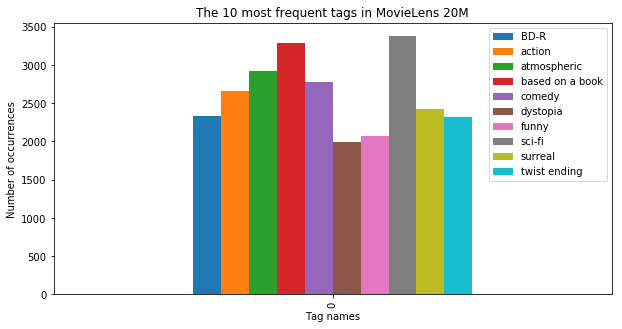

In [13]:
from collections import Counter
tags_list = tags["tag"].tolist()
tag_count = Counter(tags_list)
tag_count_10 = tag_count.most_common(10)
tag_10_dict = dict(tag_count_10)
plt.rcParams["figure.figsize"] = [10,5]


df = pd.DataFrame(tag_10_dict, index=[0])
ax = df.plot(kind='bar', title="The 10 most frequent tags in MovieLens 20M")
ax.set_xlabel("Tag names")
ax.set_ylabel("Number of occurrences")

In [14]:
links = pd.read_csv('ml-20m/links.csv')
print(links.shape)
links.head()

(27278, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


The **links** dataframe has 27278 rows and three columns labeled **movieId**, **imdbId** and **tmdbId**.

In [52]:
genome_tags = pd.read_csv('ml-20m/genome-tags.csv')
print(genome_tags.shape)
genome_tags.head()

(1128, 2)


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


The **genome_tags** dataframe has 20000263 rows and two columns labeled tagId, imdbId and tag.

In [53]:
genome_scores = pd.read_csv('ml-20m/genome-scores.csv', engine='python')
print(genome_scores.shape)
genome_scores.head()

(11709768, 3)


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


The **genome_score** dataframe has 11709768 rows and three columns labeled **movieId**, **tagId** and **relevance**.

## 2. Developing a Movie Recomendation System

We will use the Stochastic gradient descent algorithm in order to develop a movie recommendation system based on Collaborative Filtering.
In order to avoid a MemoryError, we slice the **ratings** dataframe, using only the first 400000 rows.

In [30]:
ratings = ratings.iloc[:400000,:]
print(ratings.shape)

(400000, 4)


Since we reduced the number of ratings, we also reduce the number of rows in the  **movies** dataframe, including only those rated in the 400000 row **ratings** dataframe. 

In [31]:
rated_movies_list = list(set(ratings.movieId.tolist()))
rated_movies_df = movies[movies['movieId'].isin(rated_movies_list)]

We sort the **ratings** dateframe according to **movieId** instead of **userId**.

In [32]:
ratings_sorted = ratings.sort_values("movieId")
ratings_sorted.tail()

,userId,movieId,rating,timestamp
143011,964,128715,4.0,1424133260
182289,1239,128832,4.5,1425335168
248200,1721,128842,3.0,1425957532
196973,1339,130219,4.5,1426852156
359989,2423,130490,1.0,1426887819


In order to avoid a future IndexError, we replace the movieId column of the **ratings_sorted** dataframe with a list of sequental numbers starting with zero.

In [33]:
movieId_list_unique = list(set(ratings_sorted["movieId"].tolist()))
num_of_ratings = list(range(0, ratings_sorted.shape[0]))
movieId_dict = dict(zip(movieId_list_unique, num_of_ratings))
movieId_list = ratings_sorted["movieId"].tolist()
new_movieId_list = []
counter = 0
placeholder = 1

for item in movieId_list:
    if item == placeholder:
        new_movieId_list.append(counter)
    else:
        counter += 1
        new_movieId_list.append(counter)
        placeholder = item
        
ratings_sorted["movieId"] = new_movieId_list
ratings_sorted.tail()

,userId,movieId,rating,timestamp
143011,964,11714,4.0,1424133260
182289,1239,11715,4.5,1425335168
248200,1721,11716,3.0,1425957532
196973,1339,11717,4.5,1426852156
359989,2423,11718,1.0,1426887819


We remap the movieId in the **rated_movies_df** dataframe. 

In [34]:
rated_movies_df["movieId"] = rated_movies_df.movieId.map(movieId_dict)
rated_movies_df.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We create two user-item matrices, train_data_matrix and test_data_matrix.

In [36]:
n_users = ratings_sorted.userId.unique().shape[0]
n_items = ratings_sorted.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))
train_data, test_data = cv.train_test_split(ratings_sorted, test_size=0.25)
 
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]
    
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

Number of users = 2728 | Number of movies = 11719


In [37]:
def rmse(prediction, ground_truth):
    """
    Calculates the Root Mean Squared Error.
    """
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    
    return sqrt(mean_squared_error(prediction, ground_truth))
 
def predict(ratings, similarity, type='user',epsilon=1e20):
    """
    Finds user-user similarity and item-item similarity.
    """
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred
 
def top_k_movies_byuser(prediction, mapper, user_idx, k=10):
    """
    Finds the top-k movie names based on the ordered ratings.
    """
    return [mapper[x] for x in np.argsort(prediction[user_idx,np.where(train_data_matrix[user_idx, :] == 0)[0]])[:-k-1:-1]]

def predictionSGD(P,Q):
    """
    Predicts the ratings using dot product of the latent features for users and items.
    """
    return np.dot(P.T,Q)

In [38]:
rated_movies_df.to_csv('rated_movies.txt', sep='|', index=False, header=False)
idx_to_movie = {}
with open('rated_movies.txt', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[1]

In [39]:
#Compute the cosine distance and 1-cosine distance yields cosine similarity.epsilon is used to handle the
#divide by zero scenarios
epsilon=1e-9
user_similarity = (1-pairwise_distances(train_data_matrix, metric='cosine')) + epsilon
item_similarity = (1-pairwise_distances(train_data_matrix.T, metric='cosine')) + epsilon
 
user_idx = 16

In [40]:
trainRMSE = []
testRMSE = []

pred = predict(train_data_matrix, user_similarity, type='user')
 
userBasedTrainRMSE = rmse(pred, train_data_matrix)
userBasedTestRMSE = rmse(pred, test_data_matrix)
 
trainRMSE.append(userBasedTrainRMSE)
testRMSE.append(userBasedTestRMSE)

In [41]:
print('User-based CF MSE on train data: ' + str(userBasedTrainRMSE))
print('User-based CF MSE on test data: ' + str(userBasedTestRMSE)+"\n")
print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
print(str(nearestMovies)  + "\n")
 
pred = predict(train_data_matrix, item_similarity, type='item')
 
itemBasedTrainRMSE = rmse(pred, train_data_matrix)
itemBasedTestRMSE = rmse(pred, test_data_matrix)
trainRMSE.append(itemBasedTrainRMSE)
testRMSE.append(itemBasedTestRMSE)
 
 
print('Item-based CF MSE on train data: ' + str(itemBasedTrainRMSE))
print('Item-based CF MSE on test data: ' + str(itemBasedTestRMSE)+"\n")
print("Movies recommended to user " + str(user_idx) + " are:")
 
nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
print(str(nearestMovies)  + "\n")

User-based CF MSE on train data: 3.1753436813664546
User-based CF MSE on test data: 3.2208667500873367

Movies recommended to user 16 are:
['Bitter Moon (1992)', 'Natural Born Killers (1994)', 'Rent-a-Kid (1995)', 'Slingshot, The (K?disbellan) (1993)', 'Muppet Treasure Island (1996)', 'Naked in New York (1994)', 'I.Q. (1994)', "You've Got Mail (1998)", 'When Night Is Falling (1995)', 'Poetic Justice (1993)']

Item-based CF MSE on train data: 3.34518305952029
Item-based CF MSE on test data: 3.431241653697488

Movies recommended to user 16 are:
['21 (2008)', 'Louis C.K.: Live at the Beacon Theater (2011)', 'Bad Sleep Well, The (Warui yatsu hodo yoku nemuru) (1960)', 'Date Night (2010)', 'Indian Summer (1993)', 'Sheena (1984)', 'Ice Harvest, The (2005)', 'Cowboy Bebop (1998)', 'Antibodies (Antikörper) (2005)', 'Evelyn (2002)']



In [42]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds
 
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 30)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
 
modelBasedTrainRMSE = rmse(X_pred, train_data_matrix)
modelBasedTestRMSE = rmse(X_pred, test_data_matrix)
trainRMSE.append(modelBasedTrainRMSE)
testRMSE.append(modelBasedTestRMSE)
 
print('Model-based CF MSE on train data: ' + str(modelBasedTrainRMSE))
print('Model-based CF MSE on test data: ' + str(modelBasedTestRMSE) + "\n")
 
print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_byuser(X_pred, idx_to_movie, user_idx)
print(str(nearestMovies) + "\n")
 
# Compare true ratings of user with predictions
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
ratings["Predicted Rating"] = X_pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
print(ratings)

Model-based CF MSE on train data: 2.6424701121809733
Model-based CF MSE on test data: 2.896812040856662

Movies recommended to user 16 are:
['Muppet Treasure Island (1996)', 'Bitter Moon (1992)', 'Naked in New York (1994)', 'Daens (1992)', 'Wallace & Gromit: A Close Shave (1995)', 'Wallace & Gromit: The Wrong Trousers (1993)', 'Fly Away Home (1996)', 'I.Q. (1994)', 'Poetic Justice (1993)', 'Searchers, The (1956)']

   Actual Rating  Predicted Rating
0            4.0          0.535981
1            5.0          0.913313
2            3.0          0.877623
3            3.0          0.718100
4            4.0          0.293255


In [44]:
lmbda = 0.1 # Regularisation weight
k = 20  # Dimensionality of the latent feature space
m, n = train_data_matrix.shape  # Number of users and items
iterations = 100  # Number of epochs
gamma=0.01  # Learning rate
 
user_feature = 3 * np.random.rand(k,m) # Latent user feature matrix
movie_feature = 3 * np.random.rand(k,n) # Latent movie feature matrix
train_errors = []
test_errors = []
 
#Only consider non-zero matrix
users,items = train_data_matrix.nonzero()
for iter in range(iterations):
    for u, i in zip(users,items):
        e = train_data_matrix[u, i] - predictionSGD(user_feature[:,u],movie_feature[:,i])  # Calculate error for gradient
        user_feature[:,u] += gamma * ( e * movie_feature[:,i] - lmbda * user_feature[:,u]) # Update latent user feature matrix
        movie_feature[:,i] += gamma * ( e * user_feature[:,u] - lmbda * movie_feature[:,i])  # Update latent movie feature matrix
        
    pred = predictionSGD(user_feature,movie_feature)
    train_rmse = rmse(pred, train_data_matrix)
    test_rmse = rmse(pred, test_data_matrix)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
 
# Calculate prediction matrix R_hat (low-rank approximation for R)
pred=predictionSGD(user_feature,movie_feature)
sgdBasedTrainRMSE = rmse(pred, train_data_matrix)
sgdBasedTestRMSE = rmse(pred, test_data_matrix)
trainRMSE.append(sgdBasedTrainRMSE)
testRMSE.append(sgdBasedTestRMSE)
 
print('User-based CF MSE on train data: ' + str(sgdBasedTrainRMSE))
print('User-based CF MSE on test data: ' + str(sgdBasedTestRMSE) + "\n")
 
print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
print(str(nearestMovies) + "\n")
 
# Compare true ratings of user with predictions
ratings = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
ratings["Predicted Rating"] = pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:5]
print(ratings)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in add
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').